In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import scipy.stats
import statsmodels.api as sm

/Users/atray/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
#simple function to calculate basepair composition of sequence
def bp_calc(seq):
    seqlen=len(seq)
    bpcomp=np.divide(1.0*np.array([seq.count('A'),seq.count('C'),seq.count('G'),seq.count('T')]),seqlen)
    return bpcomp

In [29]:
outputpath='OUTPUTPATH'
#minimum TPT threshold
TPT_threshold=0.02

In [10]:
#Read Dropseq outputs containing molecule information
Th=pd.read_csv('PATH2HUMAN_molBC'+'/SpeciesMix_HundredSTAMP_bq10_star_HUMAN_auto_molBC.txt.gz',sep='\t')
Tm=pd.read_csv('PATH2HUMAN_molBC'+'SpeciesMix_HundredSTAMP_bq10_star_MOUSE_auto_molBC.txt.gz',sep='\t')

In [11]:
Th['human']=[1.0]*len(Th)
Th['mouse']=[0.0]*len(Th)
Tm['human']=[0.0]*len(Tm)
Tm['mouse']=[1.0]*len(Tm)

In [12]:
Th.head()

Cell Barcode  Gene Molecular_Barcode  Num_Obs  human  mouse
0  CTAAGTAGCTTT  A1BG          CGGTCGTC        4    1.0    0.0
1  GAAGTTGGCGGA  A1BG          TCCTTTGA        3    1.0    0.0
2  GACACTTCATCG  A1BG          ATTGGCAT        2    1.0    0.0
3  GTTATCCACCTT  A1BG          CGGTCTGG        3    1.0    0.0
4  GTTATCCACCTT  A1BG          CCTGTGGG        4    1.0    0.0

In [13]:
T=pd.concat([Th,Tm])

In [14]:
T['bcumi']=[x+'-'+y for x,y in zip(T['Cell Barcode'],T['Molecular_Barcode'])]

In [15]:
BCUMI_group=T.groupby('bcumi').sum()
BCUMI_group['gpt']=BCUMI_group['human']+BCUMI_group['mouse']

In [16]:
BCUMI_group=pd.DataFrame(BCUMI_group[['Num_Obs','gpt']])
BCUMI_group.columns=['total_reads','gpt']
T_tot=T.copy()
T_tot.index=T_tot['bcumi']
T_tot=T_tot.join(BCUMI_group)
T_tot['TPT']=1.0*(np.divide(1.0*T_tot['Num_Obs'],T_tot['total_reads']))

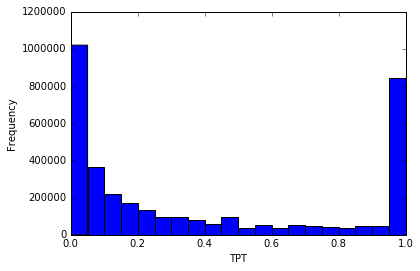

In [17]:
plt.hist(T_tot['TPT'],20)
plt.xlabel('TPT')
plt.ylabel('Frequency')

The following code computes the expected number of genes expected per unique cell barcode UMI pair based on the basepair composition diversity of the UMI

In [18]:
df_umi=pd.DataFrame([list(x) for x in T_tot['Molecular_Barcode']])
bp_umi=[bp_calc(''.join(np.array(df_umi[x]))) for x in range(np.shape(df_umi)[1])]

In [19]:
#use per base relative entropy to calculate the effective diversity of the umi library based on basepair composition bias
def s_entropy(p):
    y=[x*np.log2(x) for x in p]
    return(np.sum(y))

perbp_entropy=4.0*np.divide([s_entropy(x) for x in bp_umi],s_entropy([0.25,0.25,0.25,0.25]))

In [20]:
total_complexity=np.power(4,8)
effective_complexity=np.product(perbp_entropy)
print('total complexity would be '+str(total_complexity)+' actual complexity is '+str(effective_complexity))

total complexity would be 65536 actual complexity is 30439.0625303


In [21]:
T_tot['unique']=[1.0]*len(T_tot)
Tbc=T_tot.groupby('Cell Barcode').sum()
df_pmf=pd.DataFrame([scipy.stats.poisson.pmf(np.linspace(1,100,100),np.divide(1.0*x,effective_complexity)) for x in Tbc['unique']])
df_pmf=df_pmf.divide(df_pmf.sum(axis=1),axis=0)
df_cdfs=df_pmf.cumsum(axis=1)
mean_cdf=df_cdfs.mean()
std_cdf=df_cdfs.std()

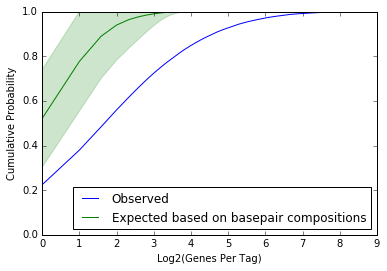

In [22]:
ysort=np.sort(np.log2(T_tot['gpt']))
y=np.cumsum(ysort)
y=np.divide(1.0*y,np.max(y))
ecdf = sm.distributions.ECDF(ysort)
x = np.log2(np.array(range(np.power(2,9)))+1)#np.linspace(min(ysort), max(ysort),10000)
y = ecdf(x)
plt.plot(x, y,label='Observed')
plt.plot(np.log2(np.linspace(1,100,100)),mean_cdf,label='Expected based on basepair compositions')
plt.fill_between(np.log2(np.linspace(1,100,100)),mean_cdf-std_cdf,mean_cdf+std_cdf,color='green',alpha=0.2)
plt.ylim([0,1])
plt.legend(loc=4)
plt.xlabel('Log2(Genes Per Tag)')
plt.ylabel('Cumulative Probability')

Now we filter on TPT and return a new expression matrix

In [30]:
filter_logical=T_tot['TPT']>TPT_threshold
T_F=T_tot[filter_logical][['Cell Barcode','Gene','unique']]
T_F.index=[(x,y) for x,y in zip(T_F['Cell Barcode'],T_F['Gene'])]
T_F=T_F.groupby(T_F.index).sum()
print('Filtered '+str(np.round(100*(1.0-np.mean(filter_logical)),2))+'% of molecules')

Filtered 16.76% of molecules


In [31]:
T_F.head()

unique
(AACCTATGGGCC, 6330408A02Rik)     1.0
(AACCTATGGGCC, A730017L22Rik)     1.0
(AACCTATGGGCC, AAAS)              2.0
(AACCTATGGGCC, AADAT)             5.0
(AACCTATGGGCC, AAED1)             1.0

In [32]:
def str2index(strlist):
    reduced=pd.DataFrame(list(set(np.sort(strlist))))
    reduced=reduced.reset_index()
    reduced.index=reduced[0]
    dftmp=pd.DataFrame(strlist,index=strlist)
    dftmp=dftmp.merge(reduced,how='left')['index']
    return np.array(dftmp),list(reduced[0])

In [33]:
tfrow=[x[1] for x in T_F.index]
tfrow,gnames=str2index(tfrow)
tfcol=[x[0] for x in T_F.index]
tfcol,cnames=str2index(tfcol)
tfdata=np.array(T_F['unique'])
tmpcol=pd.DataFrame(np.unique(tfcol))
tmpcol['unind']=range(len(tmpcol))

In [34]:
dftfcol=pd.DataFrame(tfcol)
dftfcol=dftfcol.merge(tmpcol,on=0)
tfcol=np.array(dftfcol['unind'])
EXPR_MAT=scipy.sparse.csr_matrix((tfdata,(tfrow,tfcol)),shape=(np.max(tfrow)+1,np.max(tfcol)+1)).toarray()
EXPR_MAT=pd.DataFrame(EXPR_MAT)
EXPR_MAT.index=gnames
EXPR_MAT.columns=cnames

In [37]:
#WARNING this matrix contains both human and mouse genes, but you can filter as needed
EXPR_MAT.head()

ATCTTCGGATCA  TACAATTAAGGC  TCGACCTGTACT  TCTGGATGCGCA  GGATACATGGTA  \
Plekhg2           0.0           0.0           0.0           0.0           0.0   
Plekhg3           0.0           0.0           0.0           0.0           0.0   
Plekhg4           0.0           0.0           0.0           0.0           0.0   
Plekhg5           0.0           0.0           0.0           0.0           0.0   
Nsa2              0.0           0.0           0.0           0.0           0.0   

         CACTCTGCAAGG  GAAGTTGGCGGA  AGACTTCCCTCG  AAGTAAGCAAGC  TGGCTATACCAA  \
Plekhg2           1.0           0.0           0.0           0.0           0.0   
Plekhg3           0.0           0.0           0.0           0.0           0.0   
Plekhg4           0.0           0.0           0.0           0.0           0.0   
Plekhg5           0.0           0.0           0.0           0.0           0.0   
Nsa2              1.0           0.0           0.0           0.0           0.0   

             ...       GAGACTGCCCCA  GAATGGCATGCT  CCTAGACGTAGT  TTGCCTTACGCG  \
Plekhg2      ...                0.0           0.0           0.0           0.0   
Plekhg3      ...                2.0           0.0           0.0           0.0   
Plekhg4      ...                0.0           0.0           0.0           0.0   
Plekhg5      ...                0.0           0.0           0.0           0.0   
Nsa2         ...                1.0           0.0           0.0           0.0   

         GACACTTCATCG  CGTGATGACCCT  AACCTATGGGCC  CCTTGTACTTTT  TGAATGTTTGAC  \
Plekhg2           0.0           0.0           0.0           0.0           0.0   
Plekhg3           0.0           0.0           0.0           0.0           0.0   
Plekhg4           0.0           0.0           0.0           0.0           0.0   
Plekhg5           0.0           0.0           0.0           0.0           0.0   
Nsa2              0.0           0.0           0.0           0.0           2.0   

         TCTCACAATGGG  
Plekhg2           1.0  
Plekhg3           0.0  
Plekhg4           0.0  
Plekhg5           0.0  
Nsa2              4.0  

[5 rows x 81 columns]

In [ ]:
EXPR_MAT.to_csv(outputpath+'/expr_mat_TPTfiltered.txt',sep='\t')